Scarano Gianmarco - Matricola Code: 2047315

# Import needed libraries

Google Colab sometimes ships a notebook with an outdated version of Sklearn.<br>
Please run this cell only if you are on Colab and restart the runtime, otherwise fits for the Random Forest Classifier will fail due to a missing parameter 'log_loss'.

In [ ]:
!pip install -U scikit-learn
import sklearn
print(F"{sklearn.__version__} -> (Should be >= 1.1.2)")

In [1]:
import random
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing, svm
from sklearn.ensemble import (AdaBoostClassifier, AdaBoostRegressor,
                              BaggingRegressor, GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              RandomForestClassifier, VotingClassifier,
                              VotingRegressor)
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (BayesianRidge, ElasticNet, Lasso,
                                  LogisticRegression, SGDRegressor)
from sklearn.metrics import *
from sklearn.model_selection import (GridSearchCV, KFold, cross_validate,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Load Dataset from TSV

In [2]:
# Before running this on Google Colab, make sure to upload the .tsv dataset!!

df = pd.read_csv("train_set.tsv", sep="\t", encoding='UTF8', header=0, index_col=False)

values = df.isnull().any().sum()

if(values != 0):
    print("There are some null values! Check your TSV!")
else:
    print("No null values. TSV loaded successfully.")

No null values. TSV loaded successfully.


# Classification problem

### Select TSV for Classification

In [3]:
UAV_X = df.iloc[:, :-2] # Features		  (X)
UAV_y = df.iloc[:, -2]  # Num of collisions (y)

UAV_X = UAV_X.to_numpy()
UAV_y = UAV_y.to_numpy()

# Print shapes
print("Input shape: %s" %str(UAV_X.shape))
print("Output shape: %s" %str(UAV_y.shape))
print("Number of attributes/features: %d" %(UAV_X.shape[1]))
print("Number of classes: %d" %(len(np.unique(UAV_y))))
print("Number of samples: %d" %(UAV_X.shape[0]))

# show an example
id = random.randrange(0, UAV_X.shape[0])

print("Example:")
print("x[%d] = %r" %(id,UAV_X[id]))
print("y[%d] = %r" %(id,UAV_y[id]))

Input shape: (1000, 35)
Output shape: (1000,)
Number of attributes/features: 35
Number of classes: 5
Number of samples: 1000
Example:
x[205] = array([ 1.97964015e+00, -8.03213698e+03, -3.80637805e+04,  2.11705931e+02,
       -9.17231418e+01,  5.43155703e+04, -6.50763803e+04,  2.73203699e+00,
       -6.04917847e+04,  1.56735602e+04,  8.77575375e+01, -2.02158313e+02,
       -2.71871703e+04, -6.10469683e+04,  2.32055258e+00, -6.13171965e+03,
        2.28790343e+04,  1.50790878e+02, -1.40407610e+02,  6.30264088e+04,
       -4.15169535e+04,  4.35006576e+00,  3.85943668e+04, -4.90892968e+03,
       -2.10746543e+02, -7.98850676e+01, -5.28614618e+04, -3.95759518e+04,
        2.10843006e+00, -1.27910315e+04,  7.44212130e+04,  1.85184074e+02,
       -1.10410016e+02,  5.97872985e+04,  3.11487308e+04])
y[205] = 0


### Helper functions / variables

In [4]:
# == Global variable for random state 
randomState = 2047315 # -> My matricola code :-)
#randomState = random.randrange(300000)

# == Global variable for folds
cv = 15

In [21]:
def printConfusionMatrix(targets, predictions, classifierConf, label):
    class_names = np.array(["0","1","2","3","4"])

    print(F"Classification report for {label}:")
    print(classification_report(targets, predictions, labels=None, target_names=class_names, digits=3, zero_division=0))
    print("============================================")

    cm = confusion_matrix(targets, predictions, labels=classifierConf.classes_)

    return ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifierConf.classes_)
    #disp.ax_.set_title(F'Confusion Matrix for {label}')

## Untouched Dataset

In [6]:
UAV_X_train, UAV_X_test, UAV_y_train, UAV_y_test = train_test_split(UAV_X, UAV_y, test_size=0.333, random_state=randomState, stratify=UAV_y)
print('UAV - Training set size: %d' %len(UAV_X_train))
print('UAV - Test set size: %d' %len(UAV_X_test))
('----------------------------------------------')

print(F'Shape of X values for Training set: {UAV_X_train.shape}')
print(F'Shape of Y values for Training set: {UAV_y_train.shape}')

UAV - Training set size: 667
UAV - Test set size: 333
Shape of X values for Training set: (667, 35)
Shape of Y values for Training set: (667,)


### First experiments

In [7]:
classifiers = []
clf1 = LogisticRegression(random_state=randomState, max_iter=10000)
clf2 = RandomForestClassifier(random_state=randomState)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(random_state=randomState)
clf5 = svm.SVC(cache_size=2000, random_state=randomState)

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf4), ('svc', clf5)],
     voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier', 'SVC', 'Ensemble']):
     scores = cross_validate(clf, UAV_X_train, UAV_y_train, scoring='balanced_accuracy', cv=2, return_estimator=True)
     scores = scores['test_score']
     
     print("Accuracy on test data: %0.5f" % (balanced_accuracy_score(UAV_y_test, clf.fit(UAV_X_train,UAV_y_train).predict(UAV_X_test))))
     print("Mean accuracy of folds: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))
     print("---------------------------------------------------")

Accuracy on test data: 0.18569
Mean accuracy of folds: 0.19998 (+/- 0.00343) [Logistic Regression]
---------------------------------------------------
Accuracy on test data: 0.21232
Mean accuracy of folds: 0.20826 (+/- 0.00705) [Random Forest]
---------------------------------------------------
Accuracy on test data: 0.20414
Mean accuracy of folds: 0.21672 (+/- 0.00594) [Naive Bayes]
---------------------------------------------------
Accuracy on test data: 0.18736
Mean accuracy of folds: 0.20065 (+/- 0.01588) [Gradient Boosting Classifier]
---------------------------------------------------
Accuracy on test data: 0.21070
Mean accuracy of folds: 0.20742 (+/- 0.00033) [SVC]
---------------------------------------------------
Accuracy on test data: 0.20940
Mean accuracy of folds: 0.21790 (+/- 0.00462) [Ensemble]
---------------------------------------------------


### Support Vector Classification with Kernels vs Random Forest Classifier

#### SVM Classifier

##### Grid Search for SVM Classifier

In [8]:
#The first parameter is the model
grid_search_classification = GridSearchCV(svm.SVC(random_state=randomState, cache_size=2000),
                          # Here you can choose the parameters that you want to fit in the gridsearch.
                          # In this case the gridsearch will find the best combination between 'C' and 'kernel'
                           {
                            'C':np.arange(0.1,6,0.1),
                            'gamma':('scale', 'auto'),
                            'kernel': ('rbf','sigmoid'),
                            },cv=2, scoring="balanced_accuracy",verbose=1, n_jobs=-1
                           )
print("-- Grid Search for Classification --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))

# Best parameters for the classifier
print("---------------------------------------------------------")
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

print("===================================================================")

grid_search_classification = GridSearchCV(svm.SVC(random_state=randomState, cache_size=2000),
                           {
                            'C':np.arange(0.1,6,0.1), 
                            'gamma':['scale'],          
                            'kernel': ['poly'],
                            'degree': np.arange(1,5,1),
                            }, cv=2, scoring="balanced_accuracy", verbose=10, n_jobs=-1
                          )
print("-- Grid Search for Classification with Poly Kernel --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
# Best parameters for the classifier
print("---------------------------------------------------------")
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

-- Grid Search for Classification --

Fitting 2 folds for each of 236 candidates, totalling 472 fits
GridSearchCV(cv=2, estimator=SVC(cache_size=2000, random_state=2047315),
             n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9]),
                         'gamma': ('scale', 'auto'),
                         'kernel': ('rbf', 'sigmoid')},
             scoring='balanced_accuracy', verbose=1)
---------------------------------------------------------
Best classification hyper-parameters: {'C': 3.6, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.2256
-- Grid Search for Classification with Poly Kernel --

Fitting 2 folds for each of 236 candidates, totalling 472 f

In [9]:
C = 5.9 # C = Regularization
kernel_name  = 'poly' # Kernel for the SVM: 'linear', 'poly', 'rbf', 'sigmoid'
gamma = 'scale'
degree = 2 # Degree of the polynomial fn. Only used with 'poly' kernel.
cache_size = 2000

In [10]:
classifier = svm.SVC(C=C, kernel=kernel_name, gamma=gamma, degree=degree, cache_size=cache_size, random_state=randomState)

t0 = time.time()
ll = []

classifier.fit(UAV_X_train, UAV_y_train) # These are balanced ones.
UAV_y_pred_SVM_untouched = classifier.predict(UAV_X_test)
accSVM_untouched = balanced_accuracy_score(UAV_y_test, UAV_y_pred_SVM_untouched) # These are not balanced.

eval_time = time.time() - t0
# Accuracy score. It shows the percentage of the true positive and true negative to all data points
print(F"Accuracy UAV conflicts for SVM with '{kernel_name}' kernel: {accSVM_untouched:.5f} % ({(UAV_y_pred_SVM_untouched == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_time:.3f} seconds passed")

Accuracy UAV conflicts for SVM with 'poly' kernel: 0.22549 % (162/333 correct predictions) -- 0.038 seconds passed


#### Random Forest Classifier

##### Grid Search for Random Forest Classifier

In [11]:
#The first parameter is the model
grid_search_classification = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=randomState),
                           {
                            'n_estimators':np.arange(50,400,50),                            
                            'criterion': ['gini','log_loss','entropy'],
                            'bootstrap': [True, False],
                            'warm_start': [True, False]
                            }, cv=2, scoring="balanced_accuracy", verbose=1, n_jobs=-1
                          )
print("-- Grid Search for Classification with RFC\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
#Best parameters for the classifier
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.3f" %grid_search_classification.best_score_)

-- Grid Search for Classification with RFC

Fitting 2 folds for each of 84 candidates, totalling 168 fits
GridSearchCV(cv=2,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2047315),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'log_loss', 'entropy'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                         'warm_start': [True, False]},
             scoring='balanced_accuracy', verbose=1)
Best classification hyper-parameters: {'bootstrap': False, 'criterion': 'log_loss', 'n_estimators': 150, 'warm_start': True}
Best accuracy: 0.216


In [12]:
n_estimators = 150
criterion = 'log_loss' # "entropy", "log_loss", "gini"
bootstrap = False # Use of the whole dataset for building each tree
warm_start = True # Reuse of the solution provided by the previous calls to fit()

In [13]:
classifierRFC = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap, warm_start=warm_start, random_state=randomState) 

t0 = time.time()

classifierRFC.fit(UAV_X_train, UAV_y_train)
UAV_y_pred_RFC_untouched = classifierRFC.predict(UAV_X_test)
accRFC_untouched = balanced_accuracy_score(UAV_y_test, UAV_y_pred_RFC_untouched) # These are not balanced.

eval_timeRFC = time.time() - t0
print(F"Accuracy UAV conflicts for RFC: {accRFC_untouched:.5f} % ({(UAV_y_pred_RFC_untouched == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_timeRFC:.3f} seconds passed")

Accuracy UAV conflicts for RFC: 0.20699 % (173/333 correct predictions) -- 0.324 seconds passed


### Plot the results

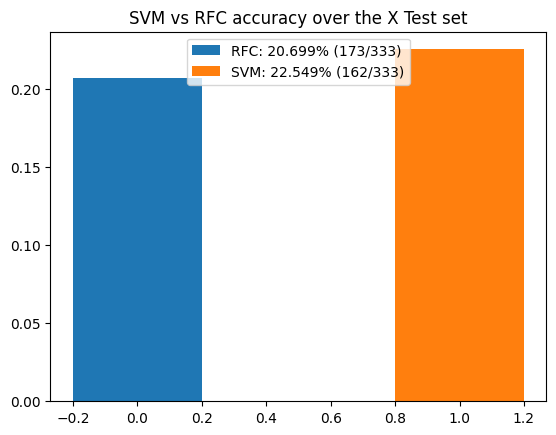

In [14]:
plt.figure()
plt.title("SVM vs RFC accuracy over the X Test set")

plt.bar(0, accRFC_untouched, width=0.4, label=F'RFC: {accRFC_untouched*100:.3f}% ({(UAV_y_pred_RFC_untouched == UAV_y_test).sum()}/{len(UAV_y_test)})')
plt.bar(1, accSVM_untouched, width=0.4, label=F'SVM: {accSVM_untouched*100:.3f}% ({(UAV_y_pred_SVM_untouched == UAV_y_test).sum()}/{len(UAV_y_test)})')

plt.legend(loc='upper center')
plt.show()

### Plot the Confusion Matrix

Classification report for SVM:
              precision    recall  f1-score   support

           0      0.597     0.687     0.639       179
           1      0.389     0.315     0.348       111
           2      0.114     0.125     0.119        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.486       333
   macro avg      0.220     0.225     0.221       333
weighted avg      0.462     0.486     0.471       333

Classification report for RFC:
              precision    recall  f1-score   support

           0      0.546     0.855     0.667       179
           1      0.392     0.180     0.247       111
           2      0.000     0.000     0.000        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.520       333
   macro avg      0.188     0.207     0.183       333
weighted avg   

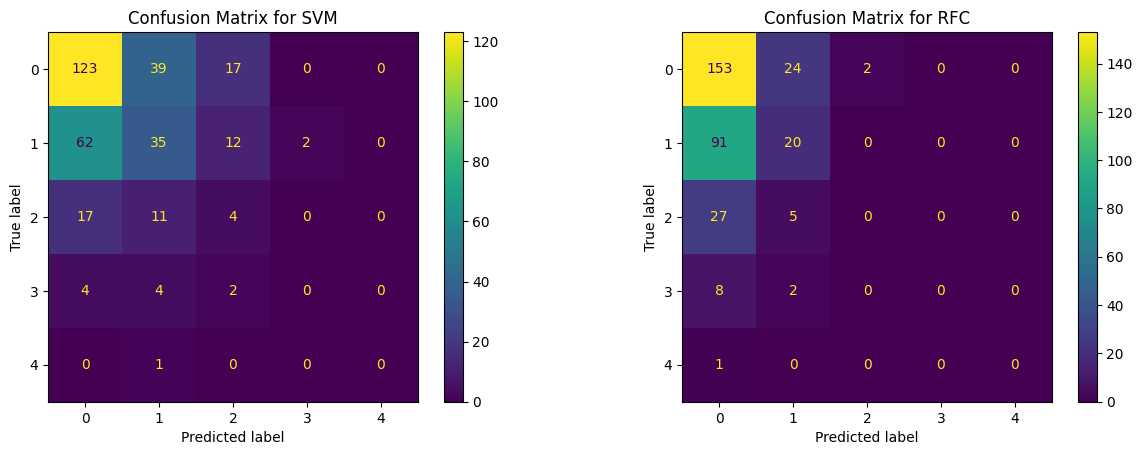

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)

axs[0].set_title('Confusion Matrix for SVM')
axs[1].set_title('Confusion Matrix for RFC')

disp = printConfusionMatrix(UAV_y_test, UAV_y_pred_SVM_untouched, classifier, 'SVM').plot(ax=axs[0])
disp2 = printConfusionMatrix(UAV_y_test, UAV_y_pred_RFC_untouched, classifierRFC, 'RFC').plot(ax=axs[1])

### Boosting with AdaBoost
AdaBoost combines weak learners.
By using SVM as base classifier for the AdaBoost, we are are loosing the concept of ensemble learning and so we are getting worst results.

In [42]:
boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': [10, 20, 30, 40, 50, 60, 70]# np.random.randint(5, 50, 5)
  }
cv = KFold(n_splits=2, shuffle=True, random_state=randomState)

all_classifiers = [[classifier, 'SVC'],
                  [classifierRFC, 'Random Forest']]

for clf in all_classifiers:
  adaboost_classifier = None
  grid_search_boosting = None
  
  clf_n = clf[1]
  classifier = clf[0]
  
  algorithm = 'SAMME' if clf_n == 'SVC' else 'SAMME.R'
  
  # Simple Boosting Classifier
  adaboost_classifier = AdaBoostClassifier(
    base_estimator=classifier,
    algorithm=algorithm,
    n_estimators=30,
    learning_rate=0.1, 
    random_state=randomState
    ).fit(UAV_X_train, UAV_y_train)

  print(F"Accuracy for the AdaBoost Classifier based on {clf_n}: {balanced_accuracy_score(UAV_y_test, adaboost_classifier.predict(UAV_X_test)):.4f}")
  
  # Grid Search for AdaBoost
  grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='balanced_accuracy', 
    cv=cv, 
    return_train_score=False,
    n_jobs=-1
  )

  grid_search_boosting.fit(UAV_X_train, UAV_y_train)

  print(F"Best classification hyper-parameters for the {clf_n} boosting classifier: {grid_search_boosting.best_params_}")
  print(F"Best accuracy for the {clf_n} boosting classifier using GridSearch: {grid_search_boosting.best_score_:.4f}")
  print(F"Accuracy of GridSearch based on {clf_n} over the test set: {balanced_accuracy_score(UAV_y_test, grid_search_boosting.predict(UAV_X_test)):.4f}")
  print("==================================================")


Accuracy for the AdaBoost Classifier based on SVC: 0.2000
Best classification hyper-parameters for the SVC boosting classifier: {'learning_rate': 0.8101595083393658, 'n_estimators': 10}
Best accuracy for the SVC boosting classifier using GridSearch: 0.2000
Accuracy of GridSearch based on SVC over the test set: 0.2000
Accuracy for the AdaBoost Classifier based on Random Forest: 0.1991
Best classification hyper-parameters for the Random Forest boosting classifier: {'learning_rate': 0.8101595083393658, 'n_estimators': 10}
Best accuracy for the Random Forest boosting classifier using GridSearch: 0.2075
Accuracy of GridSearch based on Random Forest over the test set: 0.1991


## Normalized & Balanced Dataset

### Normalization

In [24]:
scaler = MinMaxScaler()
scaler.fit(UAV_X)
UAV_X_normalized = scaler.transform(UAV_X) # Scaling values between 0 and 1

In [25]:
UAV_X_train, UAV_X_test, UAV_y_train, UAV_y_test = train_test_split(UAV_X_normalized, UAV_y, test_size=0.333, random_state=randomState, stratify=UAV_y)
print('UAV - Training set size: %d' %len(UAV_X_train))
print('UAV - Test set size: %d' %len(UAV_X_test))
('----------------------------------------------')

print(F'Shape of X values for Training set: {UAV_X_train.shape}')
print(F'Shape of Y values for Training set: {UAV_y_train.shape}')

UAV - Training set size: 667
UAV - Test set size: 333
Shape of X values for Training set: (667, 35)
Shape of Y values for Training set: (667,)


### Balance the unbalanced
As we know, the dataset here is unbalanced, meaning that the distribution over the Y vector follows the percentage in the plot below.

We use the [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) (_Random Over Sampler_) function from the Imbalanced Learn library.

This simple tool is a multi-class re-sampling function, which balances the data by oversampling the samples in the class with less samples (by picking samples at random with replacement). It re-samples each class independently.

Before SMOTE:
There are 359 samples of class 0 (53.823%)
There are 222 samples of class 1 (33.283%)
There are 64 samples of class 2 (9.595%)
There are 20 samples of class 3 (2.999%)
There are 2 samples of class 4 (0.300%)
----------------------
After SMOTE:
There are 359 samples of class 1 (20.000%)
There are 359 samples of class 3 (20.000%)
There are 359 samples of class 2 (20.000%)
There are 359 samples of class 0 (20.000%)
There are 359 samples of class 4 (20.000%)


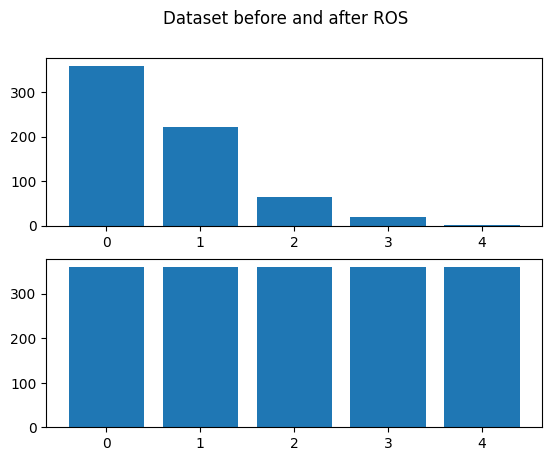

In [72]:
oversample = RandomOverSampler(random_state=randomState, sampling_strategy='not majority')

fig, axs = plt.subplots(2)
fig.suptitle('Dataset before and after ROS')

print("Before SMOTE:")
counterBeforeSMOTE = Counter(UAV_y_train)
for k, v in counterBeforeSMOTE.items():
	per = v / len(UAV_y_train) * 100
	print('There are %d samples of class %d (%.3f%%)' % (v, k, per))
axs[0].bar(counterBeforeSMOTE.keys(), counterBeforeSMOTE.values())

# ----------------------- #

UAV_X_train, UAV_y_train = oversample.fit_resample(UAV_X_train, UAV_y_train) # Oversampling of classes

#Let's shuffle the datasets once again (since SMOTE added new samples of new classes in order)
UAV_X_train, UAV_y_train = shuffle(UAV_X_train, UAV_y_train, random_state=randomState)

# ----------------------- #

print("----------------------")
counter = Counter(UAV_y_train)
print("After SMOTE:")
for k,v in counter.items():
	per = v / len(UAV_y_train) * 100
	print('There are %d samples of class %d (%.3f%%)' % (v, k, per))
# plot the distribution
axs[1].bar(counter.keys(), counter.values())
plt.show()

### First Experiments

In [29]:
classifiers = []
clf1 = LogisticRegression(random_state=randomState, max_iter=10000)
clf2 = RandomForestClassifier(random_state=randomState)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(random_state=randomState)
clf5 = svm.SVC(cache_size=2000, random_state=randomState)

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf4), ('svc', clf5)],
     voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier', 'SVC', 'Ensemble']):
     scores = cross_validate(clf, UAV_X_train, UAV_y_train, scoring='accuracy', cv=cv, return_estimator=True)
     scores = scores['test_score']
     
     print("Accuracy on test data: %0.5f" % (accuracy_score(UAV_y_test, clf.fit(UAV_X_train,UAV_y_train).predict(UAV_X_test))))
     print("Mean accuracy of folds: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))
     print("---------------------------------------------------")

Accuracy on test data: 0.24324
Mean accuracy of folds: 0.58994 (+/- 0.04613) [Logistic Regression]
---------------------------------------------------
Accuracy on test data: 0.51652
Mean accuracy of folds: 0.90978 (+/- 0.02148) [Random Forest]
---------------------------------------------------
Accuracy on test data: 0.27027
Mean accuracy of folds: 0.52754 (+/- 0.03766) [Naive Bayes]
---------------------------------------------------
Accuracy on test data: 0.40841
Mean accuracy of folds: 0.86241 (+/- 0.02555) [Gradient Boosting Classifier]
---------------------------------------------------
Accuracy on test data: 0.41141
Mean accuracy of folds: 0.83730 (+/- 0.02605) [SVC]
---------------------------------------------------
Accuracy on test data: 0.44144
Mean accuracy of folds: 0.86630 (+/- 0.02586) [Ensemble]
---------------------------------------------------


### Support Vector Classification with Kernels vs Random Forest Classifier

#### SVM Classifier

##### Grid Search for SVM Classifier

In [28]:
#The first parameter is the model
grid_search_classification = GridSearchCV(svm.SVC(cache_size=2000, random_state=randomState),
                          # Here you can choose the parameters that you want to fit in the gridsearch.
                          # In this case the gridsearch will find the best combination between 'C' and 'kernel'
                           {
                            'C':np.arange(0.1,6,0.1),
                            'gamma':['scale'],                            
                            'kernel': ('linear','rbf','sigmoid'),
                            },cv=cv, scoring="accuracy",verbose=1, n_jobs=-1
                           )
print("-- Grid Search for Classification --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))

#Best parameters for the classifier
print("---------------------------------------------------------")
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

## =================================================================== ##

grid_search_classification = GridSearchCV(svm.SVC(cache_size=2000, random_state=randomState),
                           {
                            'C':np.arange(0.1,6,0.1),                            
                            'kernel': ['poly'],
                            'degree': np.arange(1,5,1),
                            }, cv=cv, scoring="accuracy", verbose=1, n_jobs=-1
                          )
print("-- Grid Search for Classification with Poly Kernel --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
#Best parameters for the classifier
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

-- Grid Search for Classification --

Fitting 15 folds for each of 177 candidates, totalling 2655 fits
GridSearchCV(cv=15, estimator=SVC(cache_size=2000, random_state=2047315),
             n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9]),
                         'gamma': ['scale'],
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             scoring='accuracy', verbose=1)
---------------------------------------------------------
Best classification hyper-parameters: {'C': 5.5, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8864
-- Grid Search for Classification with Poly Kernel --

Fitting 15 folds for each of 236 candidates, totalling 3540 fit

In [30]:
C = 5.50 # C = Regularization
kernel_name  = 'rbf' # Kernel for the SVM: 'linear', 'poly', 'rbf', 'sigmoid'
gamma = 'scale'
degree = 4 # Degree of the polynomial fn. Only used with 'poly' kernel.
cache_size = 2000

In [31]:
classifier = svm.SVC(C=C, kernel=kernel_name, gamma=gamma, degree=degree, cache_size=cache_size, random_state=randomState)

t0 = time.time()
ll = []

classifier.fit(UAV_X_train, UAV_y_train) # These are balanced ones.
UAV_y_pred_SVM_n_b = classifier.predict(UAV_X_test)
accSVM_n_b = accuracy_score(UAV_y_test, UAV_y_pred_SVM_n_b) # These are balanced.

eval_time = time.time() - t0
# Accuracy score. It shows the percentage of the true positive and true negative to all data points
print(F"Accuracy UAV conflicts for SVM with '{kernel_name}' kernel: {accSVM_n_b:.5f} % ({(UAV_y_pred_SVM_n_b == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_time:.3f} seconds passed")

Accuracy UAV conflicts for SVM with 'rbf' kernel: 0.45045 % (150/333 correct predictions) -- 0.105 seconds passed


#### Random Forest Classifier

##### Grid Search for Random Forest Classifier

In [33]:
#The first parameter is the model
grid_search_classification = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=randomState),
                           {
                            'n_estimators':np.arange(50,400,50),                            
                            'criterion': ('gini','log_loss','entropy'),
                            'bootstrap': (True, False),
                            'warm_start': (True, False)
                            }, cv=cv, scoring="accuracy", verbose=1, n_jobs=-1
                          )
print("-- Grid Search for Classification with RFC\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
#Best parameters for the classifier
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.3f" %grid_search_classification.best_score_)

-- Grid Search for Classification with RFC

Fitting 15 folds for each of 84 candidates, totalling 1260 fits
GridSearchCV(cv=15,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2047315),
             n_jobs=-1,
             param_grid={'bootstrap': (True, False),
                         'criterion': ('gini', 'log_loss', 'entropy'),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                         'warm_start': (True, False)},
             scoring='accuracy', verbose=1)
Best classification hyper-parameters: {'bootstrap': False, 'criterion': 'log_loss', 'n_estimators': 200, 'warm_start': True}
Best accuracy: 0.922


In [34]:
n_estimators = 200
criterion = 'log_loss' # "entropy", "log_loss", "gini"
bootstrap = False # Use of the whole dataset for building each tree
warm_start = True # Reuse of the solution provided by the previous calls to fit()

In [35]:
classifierRFC = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap, warm_start=warm_start, random_state=randomState) 

t0 = time.time()

classifierRFC.fit(UAV_X_train, UAV_y_train)
UAV_y_pred_RFC_n_b = classifierRFC.predict(UAV_X_test)
accRFC_n_b = accuracy_score(UAV_y_test, UAV_y_pred_RFC_n_b) # These are balanced.

eval_timeRFC = time.time() - t0
print(F"Accuracy UAV conflicts for RFC: {accRFC_n_b:.5f} % ({(UAV_y_pred_RFC_n_b == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_timeRFC:.3f} seconds passed")

Accuracy UAV conflicts for RFC: 0.50751 % (169/333 correct predictions) -- 0.547 seconds passed


### Plot the results

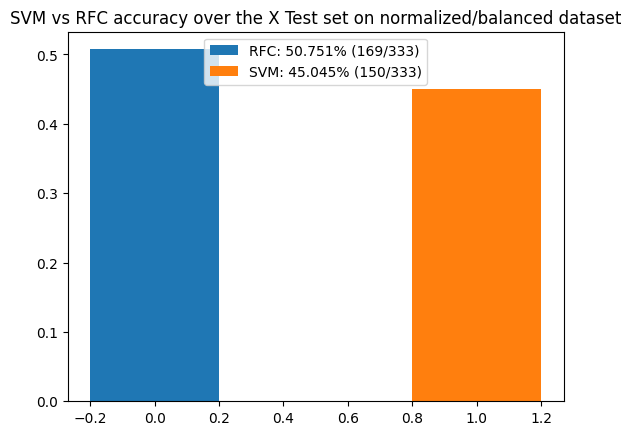

In [36]:
plt.figure()
plt.title("SVM vs RFC accuracy over the X Test set on normalized/balanced dataset")

plt.bar(0, accRFC_n_b, width=0.4, label=F'RFC: {accRFC_n_b*100:.3f}% ({(UAV_y_pred_RFC_n_b == UAV_y_test).sum()}/{len(UAV_y_test)})')
plt.bar(1, accSVM_n_b, width=0.4, label=F'SVM: {accSVM_n_b*100:.3f}% ({(UAV_y_pred_SVM_n_b == UAV_y_test).sum()}/{len(UAV_y_test)})')

plt.legend(loc='upper center')
plt.show()

### Plot the Confusion Matrix

Classification report for SVM:
              precision    recall  f1-score   support

           0      0.551     0.665     0.603       179
           1      0.300     0.270     0.284       111
           2      0.067     0.031     0.043        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.450       333
   macro avg      0.184     0.193     0.186       333
weighted avg      0.403     0.450     0.423       333

Classification report for RFC:
              precision    recall  f1-score   support

           0      0.535     0.905     0.672       179
           1      0.233     0.063     0.099       111
           2      0.000     0.000     0.000        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.508       333
   macro avg      0.154     0.194     0.154       333
weighted avg   

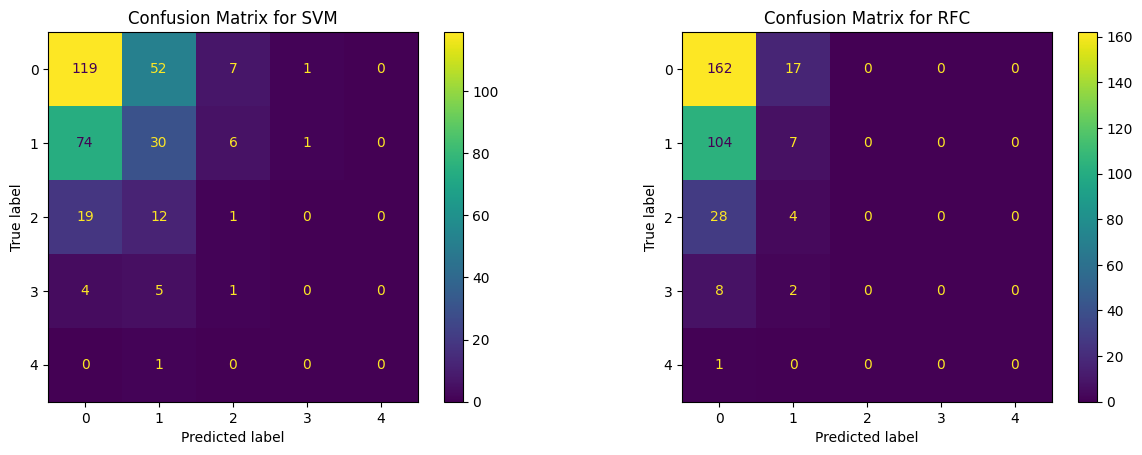

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)

axs[0].set_title('Confusion Matrix for SVM')
axs[1].set_title('Confusion Matrix for RFC')

disp = printConfusionMatrix(UAV_y_test, UAV_y_pred_SVM_n_b, classifier, 'SVM').plot(ax=axs[0])
disp2 = printConfusionMatrix(UAV_y_test, UAV_y_pred_RFC_n_b, classifierRFC, 'RFC').plot(ax=axs[1])

### Boosting with AdaBoost

In [41]:
boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': [10, 20, 30, 40, 50, 60, 70]# np.random.randint(5, 50, 5)
  }
cv_adaboost = KFold(n_splits=15, shuffle=True, random_state=randomState)

all_classifiers = [[classifier, 'SVC'],
                  [classifierRFC, 'Random Forest']]

for clf in all_classifiers:
  adaboost_classifier = None
  grid_search_boosting = None
  
  clf_n = clf[1]
  classifier = clf[0]
  
  algorithm = 'SAMME' if clf_n == 'SVC' else 'SAMME.R'
  
  # Simple Boosting Classifier
  adaboost_classifier = AdaBoostClassifier(
    base_estimator=classifier,
    algorithm=algorithm,
    n_estimators=30,
    learning_rate=0.1, 
    random_state=randomState
    ).fit(UAV_X_train, UAV_y_train)

  print(F"Accuracy for the AdaBoost Classifier based on {clf_n}: {accuracy_score(UAV_y_test, adaboost_classifier.predict(UAV_X_test)):.4f}")
  
  # Grid Search for AdaBoost
  grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='accuracy', 
    cv=cv_adaboost, 
    return_train_score=False,
    verbose=10,
    n_jobs=-1
  )

  grid_search_boosting.fit(UAV_X_train, UAV_y_train)

  print(F"Best classification hyper-parameters for the {clf_n} boosting classifier: {grid_search_boosting.best_params_}")
  print(F"Best accuracy for the {clf_n} boosting classifier using GridSearch: {grid_search_boosting.best_score_:.4f}")
  print(F"Accuracy of GridSearch based on {clf_n} over the test set: {accuracy_score(UAV_y_test, grid_search_boosting.predict(UAV_X_test)):.4f}")
  print("==================================================")


Accuracy for the AdaBoost Classifier based on SVC: 0.5135
Fitting 15 folds for each of 35 candidates, totalling 525 fits
Best classification hyper-parameters for the SVC boosting classifier: {'learning_rate': 0.5899600448168356, 'n_estimators': 10}
Best accuracy for the SVC boosting classifier using GridSearch: 0.9270
Accuracy of GridSearch based on SVC over the test set: 0.5135


## Normalized Dataset using class weights

In [42]:
UAV_X_train, UAV_X_test, UAV_y_train, UAV_y_test = train_test_split(UAV_X_normalized, UAV_y, test_size=0.333, random_state=randomState, stratify=UAV_y)
print('UAV - Training set size: %d' %len(UAV_X_train))
print('UAV - Test set size: %d' %len(UAV_X_test))
('----------------------------------------------')

print(F'Shape of X values for Training set: {UAV_X_train.shape}')
print(F'Shape of Y values for Training set: {UAV_y_train.shape}')

UAV - Training set size: 667
UAV - Test set size: 333
Shape of X values for Training set: (667, 35)
Shape of Y values for Training set: (667,)


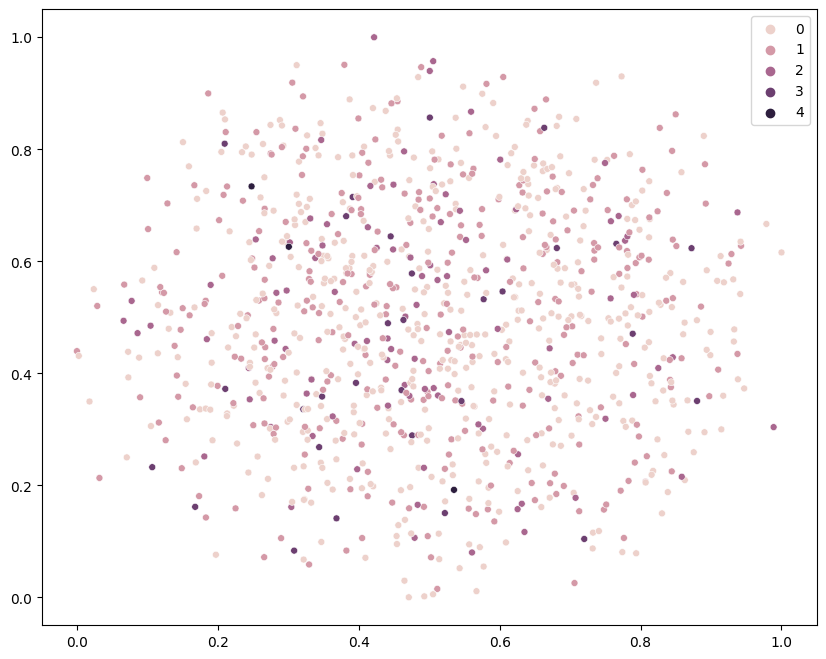

In [44]:
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=UAV_X_normalized[:, 1], 
                y=UAV_X_normalized[:, 2], 
                hue=UAV_y, 
                s=25)
plt.show()

### First experiments
We try different models at once, starting to check which one could perform better

In [48]:
cv = 2

In [49]:
# Manually calculate the weights for the classes
# Weight for class 0: n_samples / (n_classes * n_samples_class_0)
# Weight for class 1: ....

num_classes = len(np.unique(UAV_y))
weights = {
	0: 0,
	1: 0,
	2: 0,
	3: 0,
    4: 0
}
count = Counter(UAV_y)
for k, v in sorted(count.items()):
    weights[k] = len(UAV_y) / (num_classes * v)

In [50]:
clf1 = LogisticRegression(class_weight=weights, random_state=randomState, max_iter=10000)
clf2 = RandomForestClassifier(class_weight=weights, random_state=randomState)
clf3 = GaussianNB()
clf4 = GradientBoostingClassifier(random_state=randomState)
clf5 = svm.SVC(class_weight=weights, cache_size=2000, random_state=randomState)

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf4), ('svc', clf5)],
     voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier', 'SVC', 'Ensemble']):
     scores = cross_validate(clf, UAV_X_train, UAV_y_train, scoring='accuracy', cv=cv, return_estimator=True)
     scores = scores['test_score']
     
     print("Accuracy on test data: %0.5f" % (accuracy_score(UAV_y_test, clf.fit(UAV_X_train,UAV_y_train).predict(UAV_X_test))))
     print("Mean accuracy of folds: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))
     print("---------------------------------------------------")

Accuracy on test data: 0.22523
Mean accuracy of folds: 0.28036 (+/- 0.00192) [Logistic Regression]
---------------------------------------------------
Accuracy on test data: 0.52553
Mean accuracy of folds: 0.53822 (+/- 0.00969) [Random Forest]
---------------------------------------------------
Accuracy on test data: 0.45045
Mean accuracy of folds: 0.45729 (+/- 0.01418) [Naive Bayes]
---------------------------------------------------
Accuracy on test data: 0.44745
Mean accuracy of folds: 0.47529 (+/- 0.02020) [Gradient Boosting Classifier]
---------------------------------------------------
Accuracy on test data: 0.35736
Mean accuracy of folds: 0.39431 (+/- 0.00509) [SVC]
---------------------------------------------------
Accuracy on test data: 0.46246
Mean accuracy of folds: 0.48127 (+/- 0.00522) [Ensemble]
---------------------------------------------------


### Support Vector Classification with Kernels vs Random Forest Classifier

#### SVM Classifier

##### Grid Search for SVM Classifier

In [56]:
# The first parameter is the model
grid_search_classification = GridSearchCV(svm.SVC(class_weight=weights, cache_size=2000, random_state=randomState),
                          # Here you can choose the parameters that you want to fit in the gridsearch.
                          # In this case the gridsearch will find the best combination between 'C' and 'kernel'
                           {
                            'C':np.arange(0.1,6,0.1),
                            'gamma':('scale','auto'),                            
                            'kernel': ('linear','rbf','sigmoid'),
                            },cv=cv, scoring="accuracy",verbose=1, n_jobs=-1
                           )
print("-- Grid Search for Classification --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))

#Best parameters for the classifier
print("---------------------------------------------------------")
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

## =================================================================== ##

grid_search_classification = GridSearchCV(svm.SVC(class_weight=weights, cache_size=2000, random_state=randomState),
                           {
                            'C':np.arange(0.1,6,0.1),            
                            'gamma':('scale','auto'),
                            'kernel': ['poly'],
                            'degree': np.arange(1,7,1),
                            }, cv=cv, scoring="accuracy", verbose=1, n_jobs=-1
                          )
print("-- Grid Search for Classification with Poly Kernel --\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
#Best parameters for the classifier
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.4f" %grid_search_classification.best_score_)

-- Grid Search for Classification --

Fitting 2 folds for each of 354 candidates, totalling 708 fits
GridSearchCV(cv=2,
             estimator=SVC(cache_size=2000,
                           class_weight={0: 0.37174721189591076,
                                         1: 0.6006006006006006,
                                         2: 2.0833333333333335,
                                         3: 6.666666666666667,
                                         4: 66.66666666666667},
                           random_state=2047315),
             n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9]),
                         'gamma': ('scale', 'auto'),
                         'k

In [57]:
C = 5.90 # C = Regularization
kernel_name  = 'rbf' # Kernel for the SVM: 'linear', 'poly', 'rbf', 'sigmoid'
gamma = 'scale'
degree = 5 # Degree of the polynomial fn. Only used with 'poly' kernel.
cache_size = 2000

In [58]:
classifier = svm.SVC(C=C, kernel=kernel_name, gamma=gamma, degree=degree, cache_size=cache_size, class_weight=weights, random_state=randomState)

t0 = time.time()
ll = []

classifier.fit(UAV_X_train, UAV_y_train) # These are balanced ones.
UAV_y_pred_SVM_n_c = classifier.predict(UAV_X_test)
accSVM_n_c = accuracy_score(UAV_y_test, UAV_y_pred_SVM_n_c) # These are balanced.

eval_time = time.time() - t0
# Accuracy score. It shows the percentage of the true positive and true negative to all data points
print(F"Accuracy UAV conflicts for SVM with '{kernel_name}' kernel: {accSVM_n_c:.5f} % ({(UAV_y_pred_SVM_n_c == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_time:.3f} seconds passed")

Accuracy UAV conflicts for SVM with 'rbf' kernel: 0.42643 % (142/333 correct predictions) -- 0.064 seconds passed


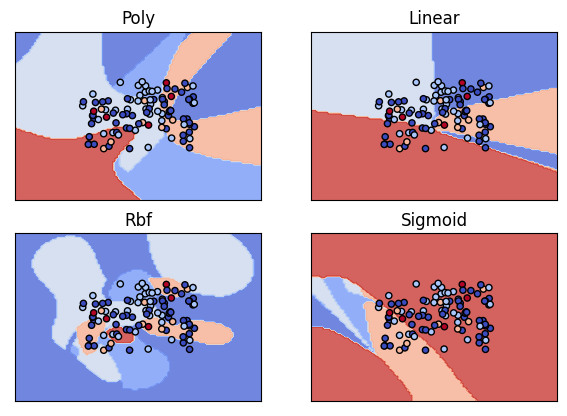

In [60]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 0.6, x.max() + 0.6
    y_min, y_max = y.min() - 0.6, y.max() + 0.6
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(7)

for i, label in zip([[0,0],[0,1],[1,0],[1,1]], ['poly', 'linear', 'rbf', 'sigmoid']):

    # 'linear', 'poly', 'rbf', 'sigmoid'
    classifier = svm.SVC(C=C, kernel=label, gamma=gamma, cache_size=cache_size, class_weight=weights, random_state=randomState)
    classifier = classifier.fit(UAV_X_train[:, :2], UAV_y_train)

    X0, X1 = UAV_X_train[:100, 0], UAV_X_train[:100, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(axs[i[0]][i[1]], classifier, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    axs[i[0]][i[1]].scatter(X0, X1, c=UAV_y_train[:100], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    axs[i[0]][i[1]].set_xticks(())
    axs[i[0]][i[1]].set_yticks(())
    axs[i[0]][i[1]].set_title(label.capitalize())

plt.show()

# Plotting only 2 features with 50 samples = https://stackoverflow.com/questions/61225052/svm-plot-decision-surface-when-working-with-more-than-2-features

#### Random Forest Classifier

##### Grid Search for Random Forest Classifier

In [61]:
#The first parameter is the model
grid_search_classification = GridSearchCV(RandomForestClassifier(n_jobs=-1, class_weight=weights, random_state=randomState),
                           {
                            'n_estimators':np.arange(50,400,50),                            
                            'criterion': ['gini','log_loss','entropy'],
                            'bootstrap': [True, False],
                            'warm_start': [True, False]
                            }, cv=cv, scoring="accuracy", verbose=1, n_jobs=-1
                          )
print("-- Grid Search for Classification with RFC\n")
print(grid_search_classification.fit(UAV_X_train,UAV_y_train))
#Best parameters for the classifier
print("Best classification hyper-parameters: %r" %grid_search_classification.best_params_)
print("Best accuracy: %.3f" %grid_search_classification.best_score_)

-- Grid Search for Classification with RFC

Fitting 2 folds for each of 84 candidates, totalling 168 fits
GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight={0: 0.37174721189591076,
                                                            1: 0.6006006006006006,
                                                            2: 2.0833333333333335,
                                                            3: 6.666666666666667,
                                                            4: 66.66666666666667},
                                              n_jobs=-1, random_state=2047315),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'log_loss', 'entropy'],
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                         'warm_start': [True, False]},
             scoring='accuracy', verbose=1)
Best classification hyper-parameters: {'bootstra

In [62]:
n_estimators = 300
criterion = 'gini' # "entropy", "log_loss", "gini"
bootstrap = True # Use of the whole dataset for building each tree
warm_start = True # Reuse of the solution provided by the previous calls to fit()

In [63]:
classifierRFC = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap, warm_start=warm_start, class_weight=weights, random_state=randomState) 

t0 = time.time()

classifierRFC.fit(UAV_X_train, UAV_y_train)
UAV_y_pred_RFC_n_c = classifierRFC.predict(UAV_X_test)

accRFC_n_c = accuracy_score(UAV_y_test, UAV_y_pred_RFC_n_c)

eval_timeRFC = time.time() - t0
print(F"Accuracy UAV conflicts for RFC: {accRFC_n_c:.5f} % ({(UAV_y_pred_RFC_n_c == UAV_y_test).sum()}/{len(UAV_y_test)} correct predictions) -- {eval_timeRFC:.3f} seconds passed")

Accuracy UAV conflicts for RFC: 0.53754 % (179/333 correct predictions) -- 0.861 seconds passed


### Plot the Confusion Matrix

Classification report for SVM:
              precision    recall  f1-score   support

           0      0.557     0.570     0.564       179
           1      0.298     0.351     0.322       111
           2      0.062     0.031     0.042        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.426       333
   macro avg      0.184     0.190     0.186       333
weighted avg      0.405     0.426     0.414       333

Classification report for RFC:
              precision    recall  f1-score   support

           0      0.550     0.961     0.699       179
           1      0.350     0.063     0.107       111
           2      0.000     0.000     0.000        32
           3      0.000     0.000     0.000        10
           4      0.000     0.000     0.000         1

    accuracy                          0.538       333
   macro avg      0.180     0.205     0.161       333
weighted avg   

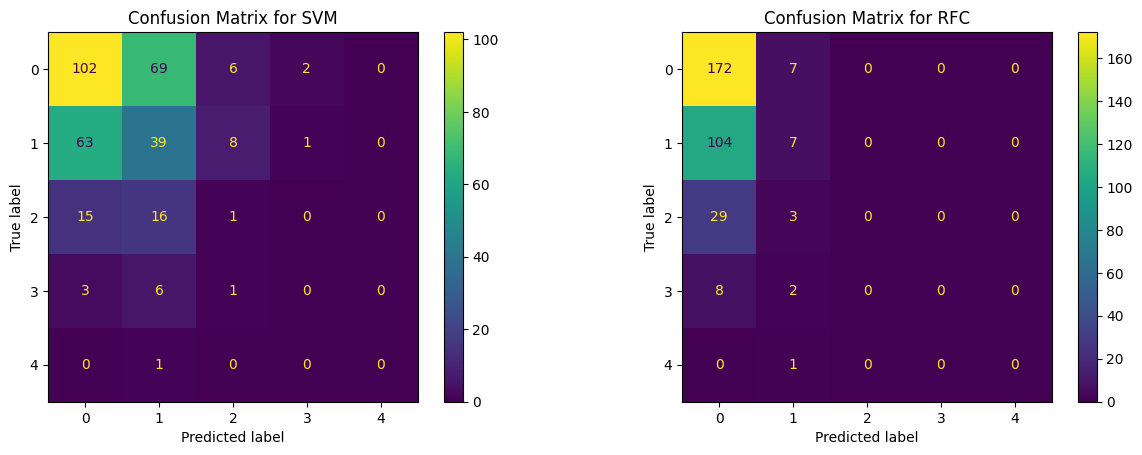

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)

axs[0].set_title('Confusion Matrix for SVM')
axs[1].set_title('Confusion Matrix for RFC')

disp = printConfusionMatrix(UAV_y_test, UAV_y_pred_SVM_n_c, classifier, 'SVM').plot(ax=axs[0])
disp2 = printConfusionMatrix(UAV_y_test, UAV_y_pred_RFC_n_c, classifierRFC, 'RFC').plot(ax=axs[1])

### Plot the results

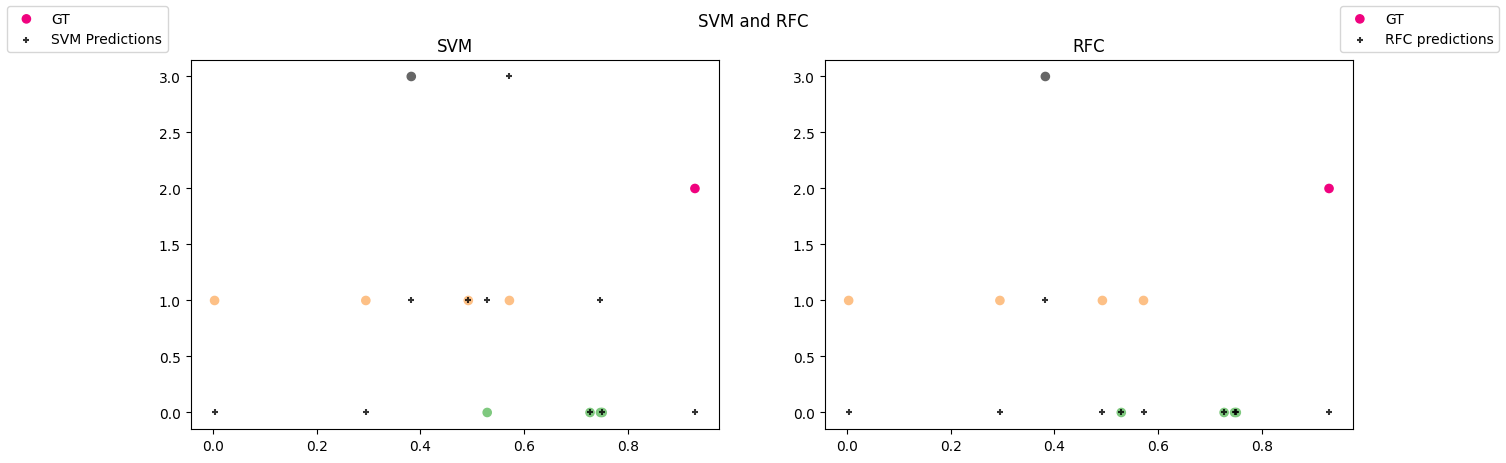

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.suptitle('SVM and RFC')

axs[0].set_title('SVM')
l1 = axs[0].scatter(UAV_X_test[:10,0], UAV_y_test[:10], s=35, c=UAV_y_test[:10], cmap='Accent',label='GT')
l1_1 = axs[0].scatter(UAV_X_test[:10,0], UAV_y_pred_SVM_n_c[:10], color='black', s=20, marker='+', alpha=0.8, label="SVM Pred")

axs[1].set_title('RFC')
l2 = axs[1].scatter(UAV_X_test[:10,0], UAV_y_test[:10], s=35, c=UAV_y_test[:10], cmap='Accent', label='GT')
l2_1 = axs[1].scatter(UAV_X_test[:10,0], UAV_y_pred_RFC_n_c[:10], color='black', s=20, marker='+', alpha=0.8, label="RFC Pred")

fig.legend((l1, l1_1), ('GT', 'SVM Predictions'), loc='upper left')
fig.legend((l2, l2_1), ('GT', 'RFC predictions'), loc='upper right')

plt.show()

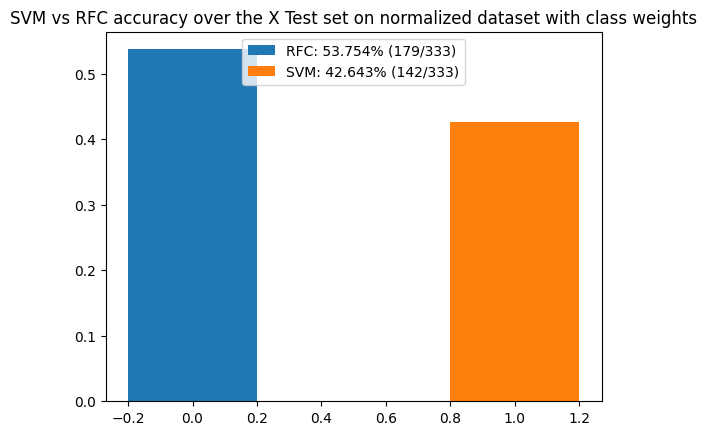

In [69]:
plt.figure()
plt.title("SVM vs RFC accuracy over the X Test set on normalized dataset with class weights")

plt.bar(0, accRFC_n_c, width=0.4, label=F'RFC: {accRFC_n_c*100:.3f}% ({(UAV_y_pred_RFC_n_c == UAV_y_test).sum()}/{len(UAV_y_test)})')
plt.bar(1, accSVM_n_c, width=0.4, label=F'SVM: {accSVM_n_c*100:.3f}% ({(UAV_y_pred_SVM_n_c == UAV_y_test).sum()}/{len(UAV_y_test)})')

plt.legend(loc='upper center')
plt.show()

## Plot the final result over all the possible test tried out

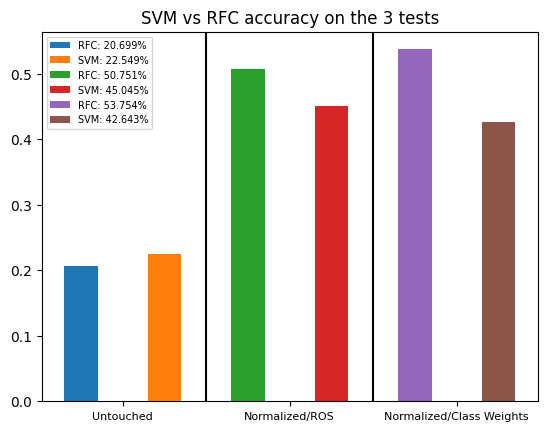

In [71]:
fig, ax = plt.subplots()
fig.canvas.draw()

plt.title("SVM vs RFC accuracy on the 3 tests")

plt.bar(0, accRFC_untouched, width=0.4, label=F'RFC: {accRFC_untouched*100:.3f}%')
plt.bar(1, accSVM_untouched, width=0.4, label=F'SVM: {accSVM_untouched*100:.3f}%')

plt.axvline(x=1.5, color='black')

plt.bar(2, accRFC_n_b, width=0.4, label=F'RFC: {accRFC_n_b*100:.3f}%')
plt.bar(3, accSVM_n_b, width=0.4, label=F'SVM: {accSVM_n_b*100:.3f}%')

plt.axvline(x=3.5, color='black')

plt.bar(4, accRFC_n_c, width=0.4, label=F'RFC: {accRFC_n_c*100:.3f}%')
plt.bar(5, accSVM_n_c, width=0.4, label=F'SVM: {accSVM_n_c*100:.3f}%')
plt.legend(loc='upper left', prop={'size': 7})

l = [0.5, 2.5, 4.5]
x = ['Untouched', 'Normalized/ROS', 'Normalized/Class Weights']

ax.set_xticks(l)
ax.set_xticklabels(x)

plt.xticks(fontsize=8)
plt.show()

# Regression Problem

## Select TSV for Regression

In [2]:
# Normalization
def normalize(set):
    
    # We don't want to track also the classification problem column
    set = set.loc[:, df.columns != 'num_collisions']

    x = set.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled)

In [5]:
df_regression = normalize(df)

UAV_X = df_regression.iloc[:, :-1] # Features   (X)
UAV_y = df_regression.iloc[:, -1]  # min_CPA    (y)

UAV_X = UAV_X.to_numpy()
UAV_y = UAV_y.to_numpy()

# Print shapes
print("Input shape: %s" %str(UAV_X.shape))
print("Output shape: %s" %str(UAV_y.shape))
print("Number of attributes/features: %d" %(UAV_X.shape[1]))
print("Number of classes: %d" %(len(np.unique(UAV_y))))
print("Number of samples: %d" %(UAV_X.shape[0]))

# show an example
id = random.randrange(0,UAV_X.shape[0])

print("Example:")
print("x[%d] = %r" %(id,UAV_X[id]))
print("y[%d] = %r" %(id,UAV_y[id]))

Input shape: (1000, 35)
Output shape: (1000,)
Number of attributes/features: 35
Number of classes: 1000
Number of samples: 1000
Example:
x[583] = array([0.91596375, 0.48358756, 0.16514033, 0.24047018, 0.93273041,
       0.25393263, 0.58413739, 0.15592577, 0.23155417, 0.0237234 ,
       0.86855594, 0.74913977, 0.85186189, 0.44021858, 0.45012296,
       0.52277619, 0.64164826, 0.63780325, 0.0732857 , 0.67534247,
       0.17966689, 0.59922148, 0.83995386, 0.43596951, 0.22896066,
       0.12890535, 0.60624465, 0.15305783, 0.25665264, 0.24025232,
       0.34279554, 0.93821866, 0.47761992, 0.82038077, 0.33412301])
y[583] = 0.052841858872201754


In [6]:
# == Global variable for random state 
randomState = 2047315 # -> My matricola code :-)
#randomState = random.randrange(300000)

In [7]:
UAV_X_train, UAV_X_test, UAV_y_train, UAV_y_test = train_test_split(UAV_X, UAV_y, test_size=0.333, random_state=randomState)
print('UAV - Training set size: %d' %len(UAV_X_train))
print('UAV - Test set size: %d' %len(UAV_X_test))
('----------------------------------------------')

print(F'Shape of X values for Training set: {UAV_X_train.shape}')
print(F'Shape of Y values for Training set: {UAV_y_train.shape}')


UAV - Training set size: 667
UAV - Test set size: 333
Shape of X values for Training set: (667, 35)
Shape of Y values for Training set: (667,)


## First Experiments

### Plot function

In [134]:
# 3D Plot Function
def plot(predictions, kernel_name):
    fig = plt.figure(dpi=125)
    fig.set_figwidth(10)

    ax = fig.add_subplot(1, 2, 1, projection='3d')        
    ax.elev = 20
    ax.azim = 20
    ax.scatter3D(UAV_X_test[:,3], UAV_y_test, edgecolors='blue', alpha=0.5)
    ax.scatter3D(UAV_X_test[:,3], predictions, 0.00, linewidth=0.5, edgecolors='red', alpha=0.7)
    
    # ==============
    # Second subplot
    # ==============
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.elev = 20
    ax.azim = 20

    ax.scatter3D(UAV_X_test[:,3], UAV_y_test, edgecolors='blue', alpha=0.5)
    ax.scatter3D(UAV_X_test[:,3], predictions, 0.02, linewidth=0.5, edgecolors='red', alpha=0.7)
    
    if kernel_name == 'rbf':
        title = "SVM 1st configuration predictions"
    elif kernel_name == 'poly':
        title = "SVM 2nd configuration predictions"
    elif kernel_name == 'bagging':
        title = "SVM 2nd configuration predictions (bagging)"
    else:
        title = ""
        
    plt.suptitle(title)            
    plt.show()

In [25]:
clf1 = SGDRegressor()
clf2 = KernelRidge()
clf3 = ElasticNet()
clf4 = BayesianRidge()
clf5 = Lasso()
clf6 = GradientBoostingRegressor()
clf7 = svm.SVR()
clf8 = KNeighborsRegressor()

eclf = VotingRegressor(
     estimators=[('SGD', clf1), ('KernelRidge', clf2), ('ElasticNet', clf3), ('Bayesian', clf4),
                 ('Lasso', clf5), ('GradientBoostingRegressor', clf6), ('SVR', clf7), ('KNeighborsRegressor', clf8)],
     n_jobs=-1)

# The reason for this is primarily the much greater interpretation of the resulting number, which makes it much easier to understand the objective performance of the model
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf], ['SGD', 'KernelRidge', 'ElasticNet', 'Bayesian', 'Lasso', 'GradientBoostingRegressor', 'SVR', 'KNeighborsRegressor','VotingRegressor']):
     UAV_y_pred = clf.fit(UAV_X_train, UAV_y_train).predict(UAV_X_test)
     score = mean_squared_error(UAV_y_test, UAV_y_pred)
     print("MSE: %0.5f [%s]" % (score, label))
     print(F"Score: {clf.score(UAV_X_test, UAV_y_test):.5f}")

MSE: 0.03610 [SGD]
Score: -0.00602
MSE: 0.03735 [KernelRidge]
Score: -0.04066
MSE: 0.03602 [ElasticNet]
Score: -0.00375
MSE: 0.03595 [Bayesian]
Score: -0.00165
MSE: 0.03602 [Lasso]
Score: -0.00375
MSE: 0.03897 [GradientBoostingRegressor]
Score: -0.08588
MSE: 0.03171 [SVR]
Score: 0.11634
MSE: 0.03643 [KNeighborsRegressor]
Score: -0.01501
MSE: 0.03413 [VotingRegressor]
Score: 0.04892


## SVR

In [135]:
kernel_name  = 'rbf' # 'linear', 'poly', 'rbf', 'sigmoid'
C = 1.0
epsilon = 0.1
cache_size = 2000

Time passed: 0.035s
MSE: 0.03171
R2 Score: 0.11634


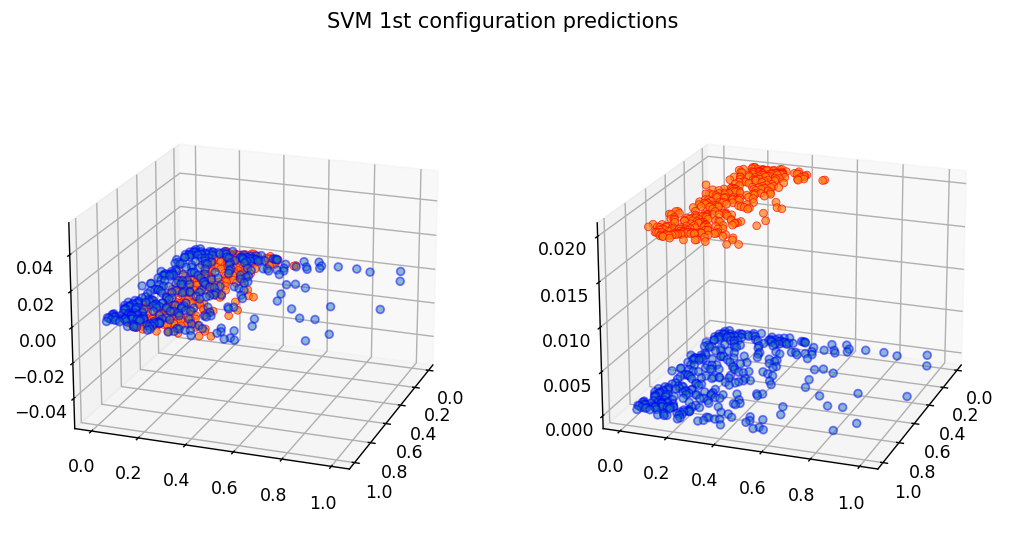

In [136]:
t0 = time.time()
regressor = svm.SVR(C=C, kernel=kernel_name, epsilon=epsilon, cache_size=cache_size)
  
# Train the regressor
regressor.fit(UAV_X_train, UAV_y_train)
UAV_y_pred = regressor.predict(UAV_X_test)

eval_time = time.time() - t0
print("Time passed: %.3fs" % eval_time)

# Check scores
print(F"MSE: {mean_squared_error(UAV_y_test, UAV_y_pred):.5f}")
print(F"R2 Score: {r2_score(UAV_y_test, UAV_y_pred):.5f}")

plot(UAV_y_pred, kernel_name)

### Grid Search for SVR

In [50]:
cv = KFold(n_splits=10, shuffle=True, random_state=randomState)

grid_search_regression = GridSearchCV(regressor,
                           {
                            'C': np.arange(0.1,5,0.1),
                            'gamma': ['scale'],                            
                            'kernel': ('rbf','sigmoid','linear'),
                            'epsilon': np.arange(0.1,3,0.1)
                            }, cv=cv, scoring="neg_mean_squared_error",verbose=1,n_jobs=-1
                           )
print("-- Grid Search for Regression --\n")

grid_search_regression.fit(UAV_X_train, UAV_y_train)
#Best parameters for the regressor
print("Best hyper-parameters for boosting regressor: %r" %grid_search_regression.best_params_)

svm_gridsearch_score = mean_squared_error(UAV_y_test, grid_search_regression.predict(UAV_X_test))
print("MSE for GridSearch on SVM: %.5f" %svm_gridsearch_score)

-- Grid Search for Regression --

Fitting 10 folds for each of 4263 candidates, totalling 42630 fits
Best hyper-parameters for boosting regressor: {'C': 0.2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
MSE for GridSearch on SVM: 0.03235


### K-Fold for SVR

In [28]:
# Let's define the K-Fold algorithm
def KFoldRegressor(regressor, cv):
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    results = cross_validate(estimator=regressor,
                            X=UAV_X,
                            y=UAV_y,
                            cv=cv,
                            scoring=scoring,
                            return_train_score=True)

    print(F"Train neg MAE (avg): {results['train_neg_mean_absolute_error'].mean():.5f}"
            F"\nTest neg MAE (avg): {results['test_neg_mean_absolute_error'].mean():.5f}"
            "\n----------------------------------------------------------"
            F"\nTrain neg MSE (avg): {results['train_neg_mean_squared_error'].mean():.5f}"
            F"\nTest neg MSE (avg): {results['test_neg_mean_squared_error'].mean():.5f}"
            "\n----------------------------------------------------------"
            F"\nTrain R2-score (avg): {results['train_r2'].mean():.5f}"
            F"\nTest R2-score (avg): {results['test_r2'].mean():.5f}"
        )

In [29]:
cv = 10
regressor = regressor
KFoldRegressor(regressor=regressor, cv=cv)

Train neg MAE (avg): -0.08265
Test neg MAE (avg): -0.14875
----------------------------------------------------------
Train neg MSE (avg): -0.00812
Test neg MSE (avg): -0.03518
----------------------------------------------------------
Train R2-score (avg): 0.77814
Test R2-score (avg): 0.00896


### Bagging and AdaBoost

In [40]:
bagging_regressor = BaggingRegressor(
    base_estimator=regressor, 
    max_samples=int(len(UAV_X_train)/2), 
    n_estimators=30,  
    random_state=randomState,
    ).fit(UAV_X_train, UAV_y_train)

UAV_y_pred = bagging_regressor.predict(UAV_X_test)
bagging_mse = mean_squared_error(UAV_y_test, UAV_y_pred)
print("MSE for Bagging  : %.5f" %bagging_mse)

adaboost_regressor = AdaBoostRegressor(
    base_estimator=regressor, 
    n_estimators=30, 
    learning_rate=1.5, 
    random_state=randomState
    ).fit(UAV_X_train, UAV_y_train)

ada_accuracy = mean_squared_error(UAV_y_test, adaboost_regressor.predict(UAV_X_test))
print("MSE for AdaBoost : %.5f" %ada_accuracy)

MSE for Bagging  : 0.03292
MSE for AdaBoost : 0.03222


In [41]:
cv = KFold(n_splits=10, shuffle=True, random_state=randomState)

# Ensemble classifier parameters
n_estimators = [10, 20, 30]  # np.random.randint(5, 50, 5)

# Bagging parameters
bagging_params = {
  'max_samples': np.random.randint(5,int(len(UAV_X_train)/2), 5),
  'n_estimators': n_estimators,
}

# Boosting parameters
boosting_params = {
  'learning_rate': np.arange(0.1,1,0.1),
  'n_estimators': [10, 20, 30, 40],
  }

grid_search_boostingR = GridSearchCV(
    adaboost_regressor,
    boosting_params, 
    scoring='neg_mean_squared_error', 
    cv=cv, 
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid_search_baggingR = GridSearchCV(
    bagging_regressor,
    bagging_params, 
    scoring='neg_mean_squared_error', 
    cv=cv, 
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid_search_boostingR.fit(UAV_X_train, UAV_y_train)
grid_search_baggingR.fit(UAV_X_train, UAV_y_train)

#Best parameters for the classifier
print("Best hyper-parameters for boosting regressor: %r" %grid_search_boostingR.best_params_)
print("Best hyper-parameters for bagging regressor: %r" %grid_search_baggingR.best_params_)

boosting_mse = mean_squared_error(UAV_y_test, grid_search_boostingR.predict(UAV_X_test))
bagging_mse = mean_squared_error(UAV_y_test, grid_search_baggingR.predict(UAV_X_test))
print("MSE for boosting: %.5f" %boosting_mse)
print("MSE for bagging: %.5f" %bagging_mse)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best hyper-parameters for boosting regressor: {'learning_rate': 0.2, 'n_estimators': 10}
Best hyper-parameters for bagging regressor: {'max_samples': 313, 'n_estimators': 30}
MSE for boosting: 0.03216
MSE for bagging: 0.03286


## SVR (2nd configuration)

In [139]:
kernel_name  = 'poly'
C = 0.1
epsilon = 0.1
degree = 4
cache_size = 2000

Time passed: 0.055s
MSE: 0.03704
R2 Score: -0.03227


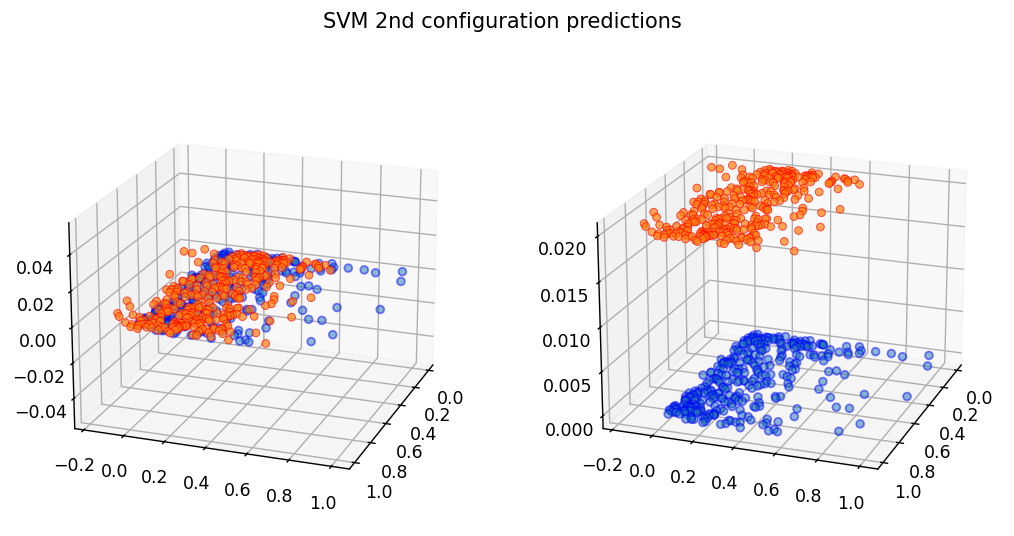

In [140]:
t0 = time.time()
regressor = svm.SVR(C=C, kernel=kernel_name, degree=degree, epsilon=epsilon, cache_size=cache_size)
  
# Train the regressor
regressor.fit(UAV_X_train, UAV_y_train)
UAV_y_pred = regressor.predict(UAV_X_test)

eval_time = time.time() - t0
print("Time passed: %.3fs" % eval_time)

# Check scores
print(F"MSE: {mean_squared_error(UAV_y_test, UAV_y_pred):.5f}")
print(F"R2 Score: {r2_score(UAV_y_test, UAV_y_pred):.5f}")

plot(UAV_y_pred, kernel_name)

### GridSearch for SVR - 2nd config

In [124]:
cv = KFold(n_splits=10, shuffle=True, random_state=randomState)

grid_search_regression = GridSearchCV(regressor,
                           {
                            'C': np.arange(0.1,5,0.1),
                            'gamma': ['scale'],                            
                            'kernel': ['poly'],
                            'degree': np.arange(1,6,1),
                            'epsilon': np.arange(0.1,3,0.1)
                            }, cv=cv, scoring="neg_mean_squared_error",verbose=1,n_jobs=-1
                           )
print("-- Grid Search for Regression --\n")

grid_search_regression.fit(UAV_X_train, UAV_y_train)
#Best parameters for the regressor
print("Best hyper-parameters for boosting regressor: %r" %grid_search_regression.best_params_)
print("Best MSE: %.5f" %grid_search_regression.best_score_)

svm_gridsearch_score = mean_squared_error(UAV_y_test, grid_search_regression.predict(UAV_X_test))
print("MSE for GridSearch on SVM: %.5f" %svm_gridsearch_score)

-- Grid Search for Regression --

Fitting 10 folds for each of 7105 candidates, totalling 71050 fits
Best hyper-parameters for boosting regressor: {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Best MSE: -0.03661
MSE for GridSearch on SVM: 0.03209


### Bagging and AdaBoost - SVR - 2nd config

MSE for Bagging  : 0.03199
MSE for AdaBoost : 0.03506


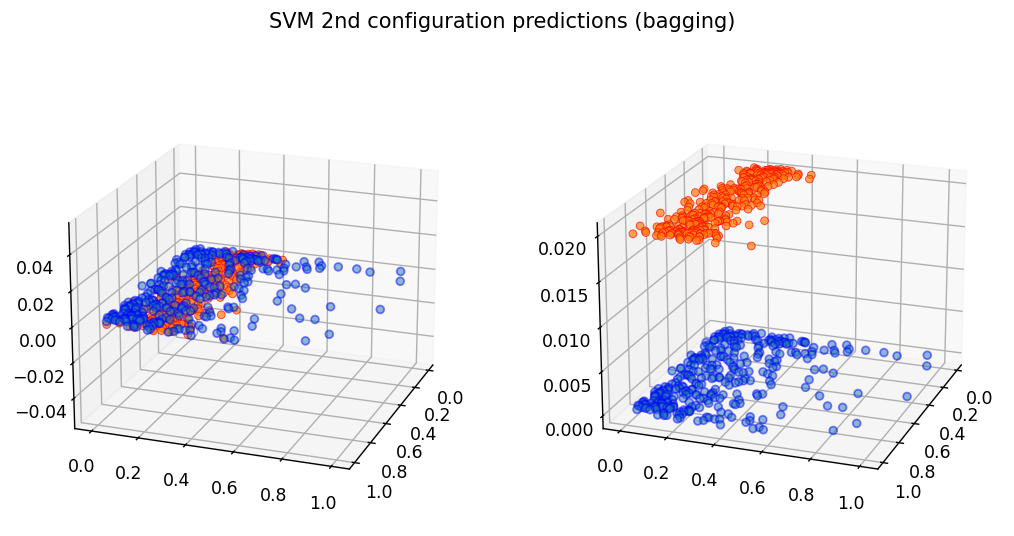

In [142]:
n_estimators_bagging = 50
n_estimators_boosting = 50
lr = 1.0
max_samples = 500

bagging_regressor = BaggingRegressor(
    base_estimator=regressor, 
    max_samples=311, 
    n_estimators=n_estimators_bagging,  
    random_state=randomState,
    ).fit(UAV_X_train, UAV_y_train)

UAV_y_pred = bagging_regressor.predict(UAV_X_test)
bagging_mse = mean_squared_error(UAV_y_test, UAV_y_pred)
print("MSE for Bagging  : %.5f" %bagging_mse)

adaboost_regressor = AdaBoostRegressor(
    base_estimator=regressor, 
    n_estimators=n_estimators_boosting, 
    learning_rate=lr, 
    random_state=randomState
    ).fit(UAV_X_train, UAV_y_train)

ada_accuracy = mean_squared_error(UAV_y_test, adaboost_regressor.predict(UAV_X_test))
print("MSE for AdaBoost : %.5f" %ada_accuracy)
plot(UAV_y_pred, 'bagging')

In [130]:
cv = KFold(n_splits=10, shuffle=True, random_state=randomState)

# Ensemble classifier parameters
n_estimators = [10, 20, 30]  # np.random.randint(5, 50, 5)

# Bagging parameters
bagging_params = {
  'max_samples': np.random.randint(5,int(len(UAV_X_train)/2), 5),
  'n_estimators': n_estimators,
}

# Boosting parameters
boosting_params = {
  'learning_rate': np.arange(0.1,1,0.1),
  'n_estimators': [10, 20, 30, 40],
  }

grid_search_boostingSVR2 = GridSearchCV(
    adaboost_regressor,
    boosting_params, 
    scoring='neg_mean_squared_error', 
    cv=cv, 
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid_search_baggingSVR2 = GridSearchCV(
    bagging_regressor,
    bagging_params, 
    scoring='neg_mean_squared_error', 
    cv=cv, 
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

grid_search_boostingSVR2.fit(UAV_X_train, UAV_y_train)
grid_search_baggingSVR2.fit(UAV_X_train, UAV_y_train)

#Best parameters for the classifier
print("Best hyper-parameters for boosting regressor: %r" %grid_search_boostingSVR2.best_params_)
print("Best hyper-parameters for bagging regressor: %r" %grid_search_baggingSVR2.best_params_)

boosting_mse = mean_squared_error(UAV_y_test, grid_search_boostingSVR2.predict(UAV_X_test))
bagging_mse = mean_squared_error(UAV_y_test, grid_search_baggingSVR2.predict(UAV_X_test))
print("MSE for boosting: %.5f" %boosting_mse)
print("MSE for bagging: %.5f" %bagging_mse)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best hyper-parameters for boosting regressor: {'learning_rate': 0.2, 'n_estimators': 10}
Best hyper-parameters for bagging regressor: {'max_samples': 111, 'n_estimators': 30}
MSE for boosting: 0.03371
MSE for bagging: 0.03436
